# Read csv

In [1]:
import pandas
import numpy
import sys
import os.path
import matplotlib.pyplot as plt

model = 'model'
tolerance = 'tolerance'
point_id = 'point_id'
time = 'time'
value = 'value'

headers = [model, tolerance, point_id, time, value]
types = {
    model : str,
    tolerance : numpy.float64,
    point_id: numpy.int64,
    time : numpy.int64,
    value: numpy.float64,
}

df = pandas.read_csv('tolerance_tests.csv', header = 0, names = headers, low_memory = False, dtype = types)
# df

# Mean runtime with different tolerance

In [2]:
sum_times_df = df.loc[:,[model,tolerance,time]].groupby([model,tolerance]).mean().sort_values(by=[model, tolerance])

models = sum_times_df.index.levels[0].tolist()
tols = sum_times_df.index.levels[1].tolist()

sum_times_df = sum_times_df.reset_index()
for mod in models:
    tempDf = sum_times_df[sum_times_df.model == mod]
    for t in tols:
        tempDf_tol = tempDf[tempDf.tolerance == t]
        if len(tempDf_tol) == 0:
            sum_times_df.loc[-1] = [mod, t, 0]  # adding a row
            sum_times_df.index = sum_times_df.index + 1  # shifting index
            sum_times_df = sum_times_df.sort_values(by=[model,tolerance])  # sorting by index

# sum_times_df

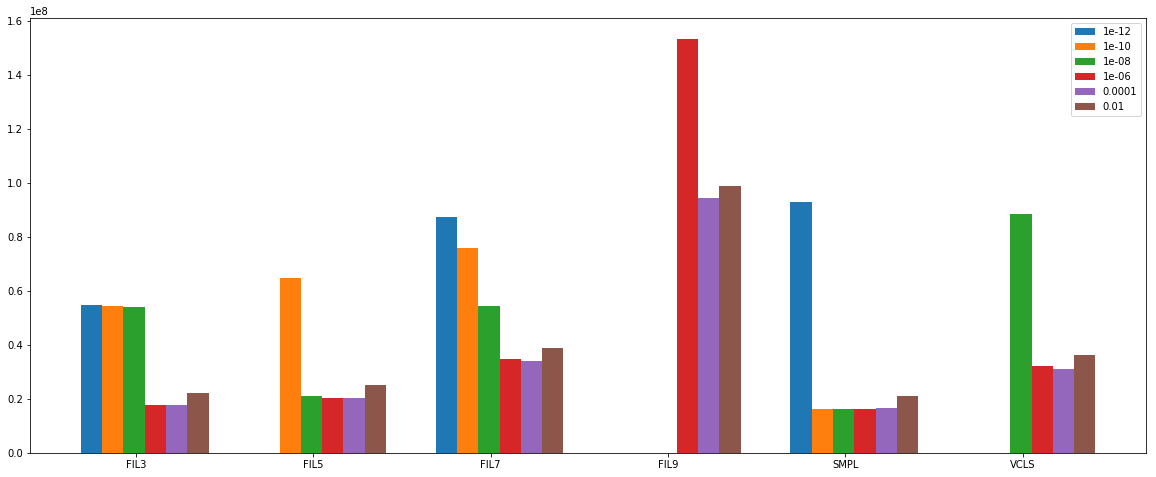

In [3]:
arrays=[]
for x in tols:
    arrays.append([])

tasks = sum_times_df.loc[:,time].reset_index()
tasks['index'] = numpy.arange(tasks.time.count())
for x in range(tasks.time.count()):
    nextTime = tasks.loc[tasks['index']==x].iloc[0].time
    arrays[x%len(tols)].append(nextTime)

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

ind = numpy.arange(6)  # the x locations for the groups
xIdx = -0.25
wi = 0.12
i = 0
for array in arrays:
    ax.bar(height=array, x=ind+xIdx, width=wi, label=tols[i])
    xIdx = xIdx + wi
    i = i+1
    
ax.set_xticks(ind)
ax.set_xticklabels(models)
plt.legend()
plt.show()

# Result variance at different tolerances

In [10]:
temp_df = df.loc[:,[model, point_id, value]]\
            .groupby([model, point_id]).var()\
            .groupby(model).mean()
temp_df

,value
model,
FIL3,2.782330e+21
FIL5,1.463393e+03
FIL7,1.063926e+05
FIL9,9.658554e-07
SMPL,0.000000e+00
VCLS,6.688570e+129
